# Smart Meters in London: Data Analysis and ML model (Part 3/3)

According to the objectives we want to analyse, this jupyter notebook wants to investigate into the data coming from the energy consumption of different users, to see how later on a forecast algorithm can be developed, or clustering models can be done. Also, in order to provide smart services to the end-user, it would be useful for the end-user to see their energy consumption in different timeframes: hourly, daily, weekly, monthly, and yearly. 

The structure of this notebook is as follows: 

1. Preprocessing: Libraries and files reading 
2. Client Analysis: Visualization and Differences between tariffs

 2.1. Types of Tariffs and clients associated to each one. 
 
 2.2. Standard Users
    
  * Std User: MAC000291
        
  * Std User: MAC004280
       
  2.3. ToU Users
    
   * ToU User: MAC001495
     
   * ToU User: MAC002645
      
  2.4. Conclusions
    
    
3.  Clients Cluster

    3.1. Daily Data Preprocessing
    
    3.2. ML Model: Clustering
    
       * K-Means model.
                  
       * DBSCAN model 
         
    3.3. Conclusions


## 1. Preprocessing: Libraries and files reading

In [348]:
# Libraries for math and data wrangling
import pandas as pd 
import numpy as np 
import datetime as dt
import os
import sklearn 

# Libraries for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns 

# plotly library for interacive plots
import plotly.offline as py;
from plotly import tools;
import plotly.graph_objs as go;
import warnings;
from ipywidgets import widgets;
from ipywidgets import interact;

warnings.filterwarnings('ignore')
py.init_notebook_mode(connected=True)

# Seting style for matplotlib
plt.style.use('ggplot')

In [189]:
# Reading the current working directoy to see where are we writing the code. 
os.getcwd()

'/home/ingrid/Documents/DA_Ironhack/Week8/Final_Project/2.JupyterNotebooks'

In [190]:
# Seeing all the files we have in clean_data folder 
os.listdir('../0.Data/clean_data')

['halfhourly_block12_cleaned.csv',
 'MAC000291_cleaned_consumption.csv',
 'info_househoulds_cleaned.csv',
 'weather_hourly_cleaned.csv',
 'info_households_cleaned.csv']

In [191]:
# Reading the csv file
users_info = pd.read_csv('../0.Data/clean_data/info_househoulds_cleaned.csv', index_col=0)

In [192]:
users_info.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [193]:
# Changing the name of the columns to a better one. 
users_info.columns = ['LCLid', 'tariff', 'acorn_class', 'acorn_group', 'file']

In [194]:
# Counting how many clients we have under each type of tariff.
users_info['tariff'].value_counts()

Std    4443
ToU    1123
Name: tariff, dtype: int64

## 2. Clients Analysis: Visualization and Differences between tariffs

In this section we want to analyse the current tariff our clients have contracted. Later on, we will analyse some of the users on each tariff to see whether there are seasonality patterns, as well as if there are differences between users based on their energy consumption. We will take two users for each type of contract. 

### 2.1. Types of tariff and clients associated to each one. 

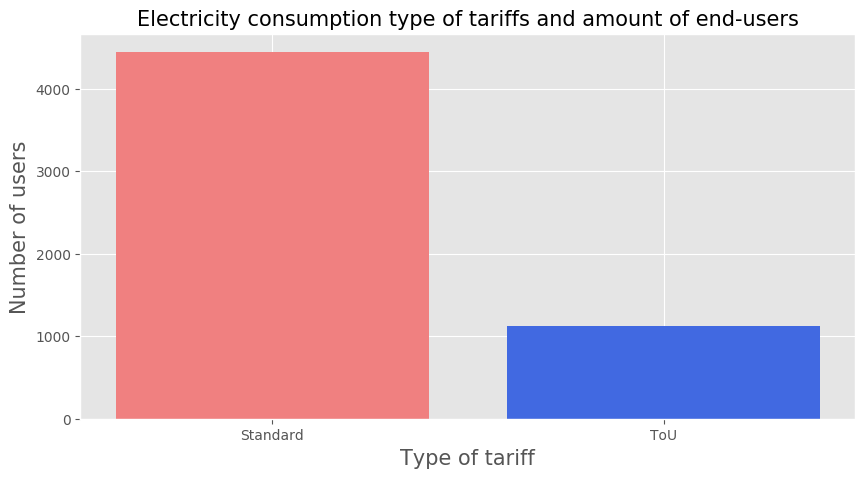

In [195]:
# Plotting how many clients we have under each tariff 
plt.figure(figsize=(10,5))
plt.bar(x=['Standard','ToU'], height=users_info['tariff'].value_counts(), color=['lightcoral', 'royalblue'])

# Setting aesthetics on the plot 
plt.title("Electricity consumption type of tariffs and amount of end-users", fontsize=15)
plt.ylabel("Number of users", fontsize=15)
plt.xlabel('Type of tariff', fontsize=15)

#plt.savefig('../3.Figures/Tariff_users.png', dpi=300)
plt.show()

As we can see from the graph above, there are two different types of tariff that the user can contract: **Standard** and **ToU**. Also we can see that there is a huge tendency on the amount of users to have a Standard contract instead of a ToU contract. We have 4443 users with a Standard contract and only 1123 users with a ToU contract. That means that nearly 80% of the users have a Standard contract whereas the 20% has a ToU contract.


We will choose two end-users with a Standard Tariff contracted and later on we will choose two end-users with a ToU tariff, to see whether there are significant differences in the model. 

Since we have cleaned the data belonging to block_12, we will first analyse those end users that belong to each type of tariff and also belong to block_12.

In [197]:
# Filtering our dataframe to those that have a ToU tariff and belong to block_12
users_info[(users_info['tariff']=='ToU') & (users_info['file']=='block_12')].head()

,LCLid,tariff,acorn_class,acorn_group,file
600,MAC005106,ToU,ACORN-D,Affluent,block_12
604,MAC005179,ToU,ACORN-D,Affluent,block_12
610,MAC001495,ToU,ACORN-D,Affluent,block_12
611,MAC002622,ToU,ACORN-D,Affluent,block_12
613,MAC002645,ToU,ACORN-D,Affluent,block_12


In [198]:
# Filtering our dataframe to those that have a Std tariff and belong to block_12
users_info[(users_info['tariff']=='Std') & (users_info['file']=='block_12')].head()

,LCLid,tariff,acorn_class,acorn_group,file
601,MAC004340,Std,ACORN-D,Affluent,block_12
602,MAC002137,Std,ACORN-D,Affluent,block_12
603,MAC001800,Std,ACORN-D,Affluent,block_12
605,MAC005182,Std,ACORN-D,Affluent,block_12
606,MAC004280,Std,ACORN-D,Affluent,block_12


We will use the data coming from two users with ToU Tariff and two with Std Tariff that they are also in block_12 since it is the block that we have cleaned before. We will import block_12 to analyse these data. 

`ToU users`: MAC001495 and MAC002645

`Standard users`: MAC001800 and MAC004280 and MAC000291

In [318]:
# Importing block_12 file 
half_hourly_df = pd.read_csv('../0.Data/clean_data/halfhourly_block12_cleaned.csv')
half_hourly_df.drop('Unnamed: 0', axis=1, inplace= True)

### 2.2 Standard users analysis
#### 2.2.1. Std User: MAC000291

In [313]:
MAC000291_df = half_hourly_df[half_hourly_df['LCLid']=='MAC000291']

In [316]:
def df_arrange(df, id_column, dt_column):
    # Changing the type of DateTime column into DateTime 
    
    df[dt_column] = pd.to_datetime(df[dt_column])

    # Setting DateTime as index of the dataframe 
    df.index = df[dt_column].sort_index()

    # Droping DateTime and LCLid columns 
    df.drop([id_column, dt_column], axis = 1, inplace = True )
    
    # Changing names of the columns
    df.columns= ['kWh']
    
    # Resample df into hourly data 
    return df.resample('H').sum()

In [317]:
MAC000291_df_h = MAC000291_df.copy()
MAC000291_df_h = df_arrange(MAC000291_df_h, 'LCLid', 'DateTime' )

In [331]:
MAC000291_df_h.head()

,kWh
DateTime,
2012-03-02 09:00:00,1.158
2012-03-02 10:00:00,2.932
2012-03-02 11:00:00,0.965
2012-03-02 12:00:00,0.734
2012-03-02 13:00:00,0.694


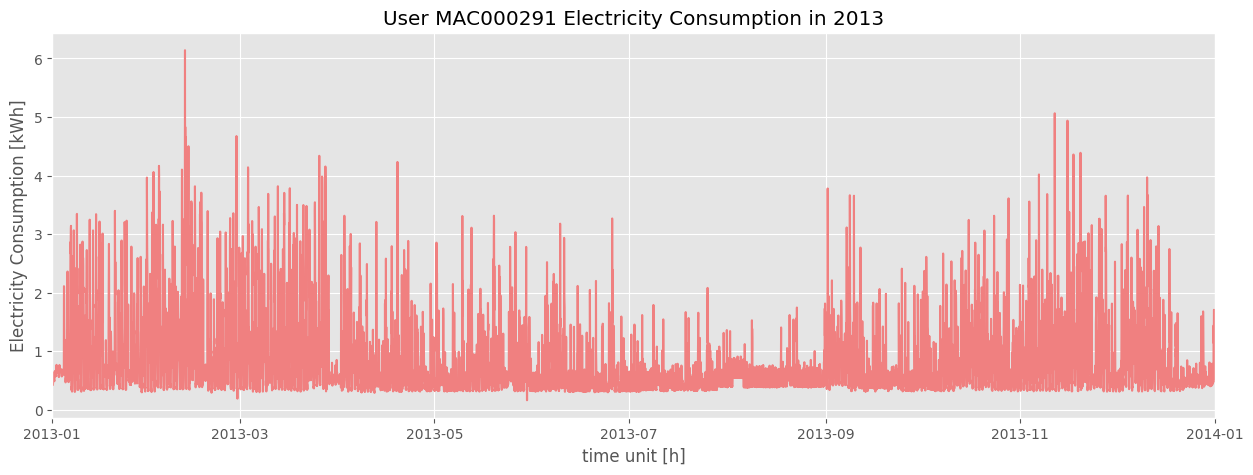

In [206]:
plt.figure(figsize=(15,5))
plt.plot(MAC000291_df_h['2013'], color='lightcoral')
#plt.plot(moving_avg_24h, color='royalblue' )
plt.title('User MAC000291 Electricity Consumption in 2013')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-01-01 00:00:00', '2014-01-01 00:00:00')
plt.show()

When dealing with time-series data and plotting them,, it can be difficult to see some patterns of trends in such a small timescale as hours, with a timespan of 1 year. However, we can see that for example in Summer the overall consumption is lower than in Winter periods. In order to have a better understanding of the data, we will plot just one month to see the electricity consumption on that time period. 

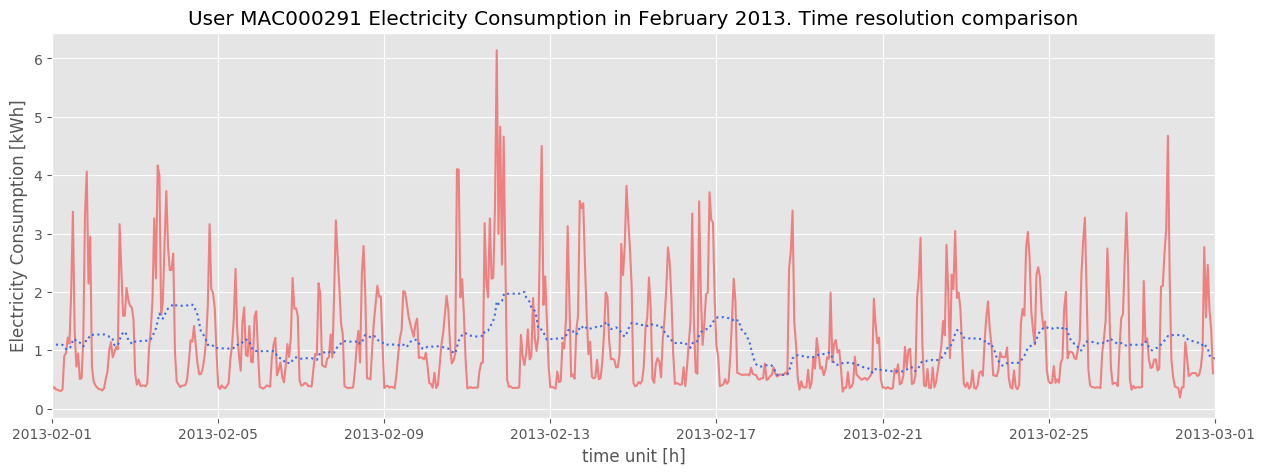

In [207]:
plt.figure(figsize=(15,5))
plt.plot(MAC000291_df_h['2013-02'], color='lightcoral')
plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
plt.title('User MAC000291 Electricity Consumption in February 2013. Time resolution comparison')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-01 00:00:00', '2013-03-01 00:00:00')
plt.show()

In [411]:
fig = go.Figure()


fig.add_trace(go.Line(x=MAC000291_df_h['2013-02'].index,
                      y=MAC000291_df_h['2013-02']['kWh'], name="MAC000291"));


fig.add_trace(go.Line(x=moving_avg_24h['2013-02'].index,
                      y=moving_avg_24h['2013-02']['kWh'], name="moving average", 
                      line = dict(color='lightcoral', width=2, dash='dot')));


fig.update_layout(
    title=go.layout.Title(text="MAC000291 User Electricity Consumption", xref="paper", x=0, 
                          font=dict(family="Courier New, monospace", size=18, color="#7f7f7f")),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Date", font=dict(family="Courier New, monospace",
                          size=18, color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Electricity consumption [kWh]",
                          font=dict(family="Courier New, monospace", size=18, color="#7f7f7f"))))

fig.show()


In this case we can start seeing some trends and patterns on each day. 

In [208]:
moving_avg_1h = MAC000291_df_h.rolling(window=1).mean()
moving_avg_2h = MAC000291_df_h.rolling(window=2).mean()
moving_avg_12h = MAC000291_df_h.rolling(window=12).mean()
moving_avg_24h = MAC000291_df_h.rolling(window=24).mean()

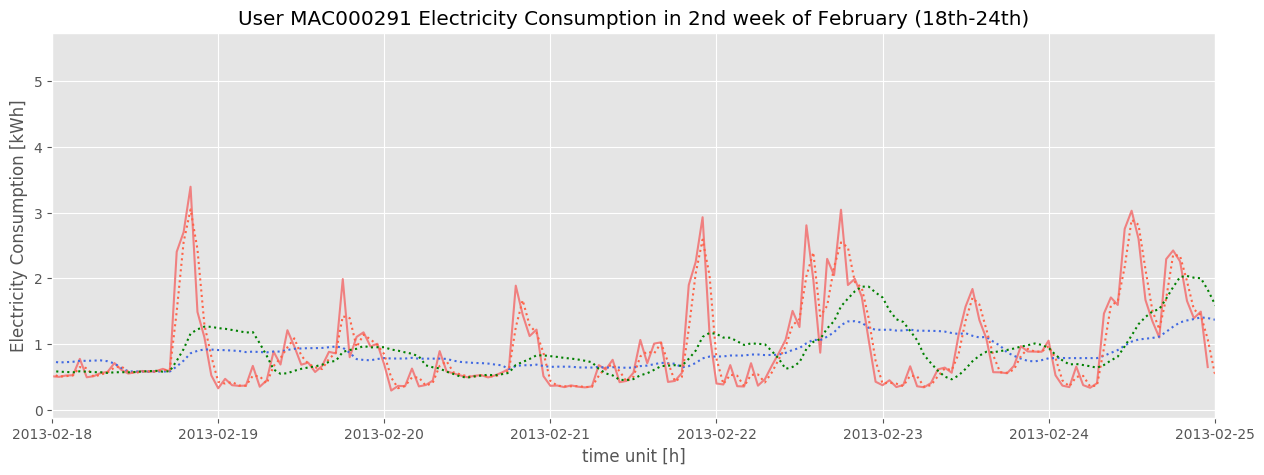

In [209]:
plt.figure(figsize=(15,5))
plt.plot(MAC000291_df_h['2013-02-18':'2013-02-24'], color='lightcoral')
#plt.plot(moving_avg_1h, color='black', linestyle=':' )
plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
plt.plot(moving_avg_2h, color='tomato', linestyle=':' )
plt.plot(moving_avg_12h, color='green', linestyle=':' )
plt.title('User MAC000291 Electricity Consumption in 2nd week of February (18th-24th)')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-18 00:00:00', '2013-02-25 00:00:00')
plt.show()

In [371]:
# Traces
traces = [go.Line(x=MAC000291_df_h['2013-02-18':'2013-02-24'].index, y=MAC000291_df_h['2013-02-18':'2013-02-24']['kWh'])]; 
      
# Layout
layout = go.Layout(width=1000, height=500,
                   xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Date')),
                   yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Energy consumption [kWh]')),
                   title=go.layout.Title(text='User MAC000291. Electricity Consumption in February 2013 (18th-24th)'));

# Plot
py.iplot(go.Figure(data=traces, layout=layout));

#### 2.2.2. Std User: MAC004280

In [324]:
MAC004280_df = half_hourly_df[half_hourly_df['LCLid']=='MAC004280']
MAC004280_df_h = MAC004280_df.copy()
MAC004280_df_h = df_arrange(MAC004280_df_h , 'LCLid', 'DateTime' )

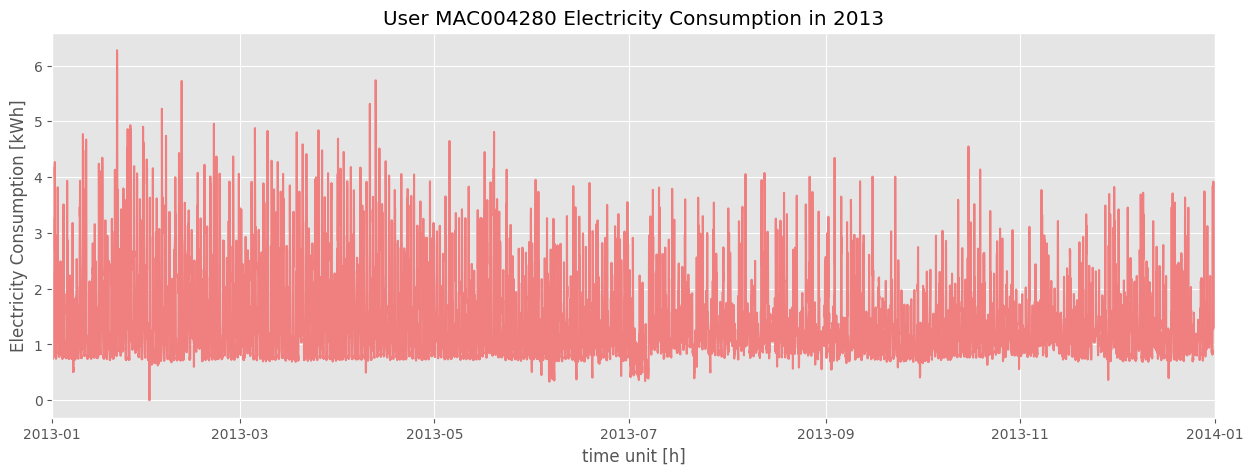

In [325]:
plt.figure(figsize=(15,5))
plt.plot(MAC004280_df_h['2013'], color='lightcoral')
#plt.plot(moving_avg_24h, color='royalblue' )
plt.title('User MAC004280 Electricity Consumption in 2013')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-01-01 00:00:00', '2014-01-01 00:00:00')
plt.show()

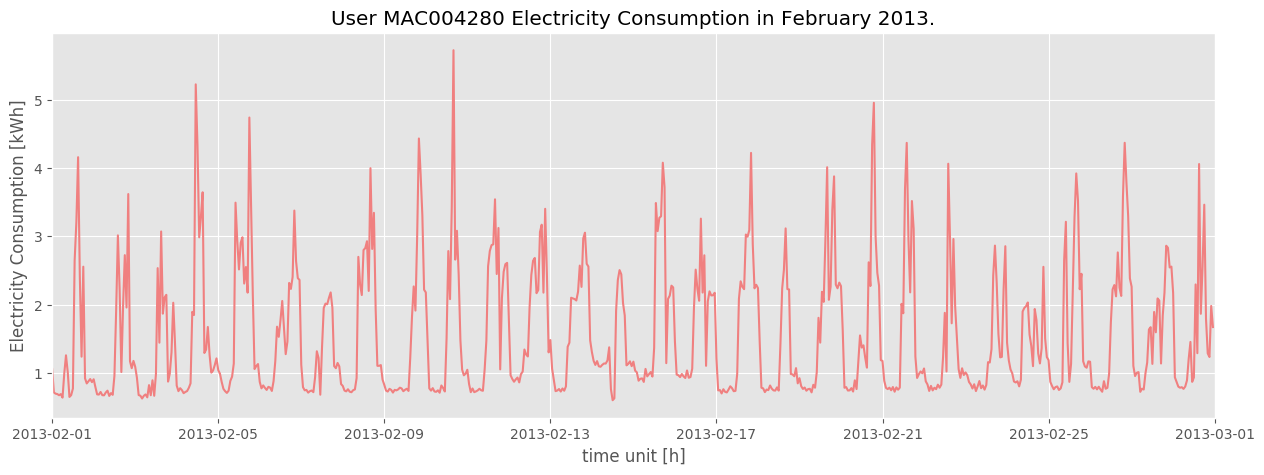

In [212]:
plt.figure(figsize=(15,5))
plt.plot(MAC004280_df_h['2013-02'], color='lightcoral')
#plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
plt.title('User MAC004280 Electricity Consumption in February 2013.')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-01 00:00:00', '2013-03-01 00:00:00')
plt.show()

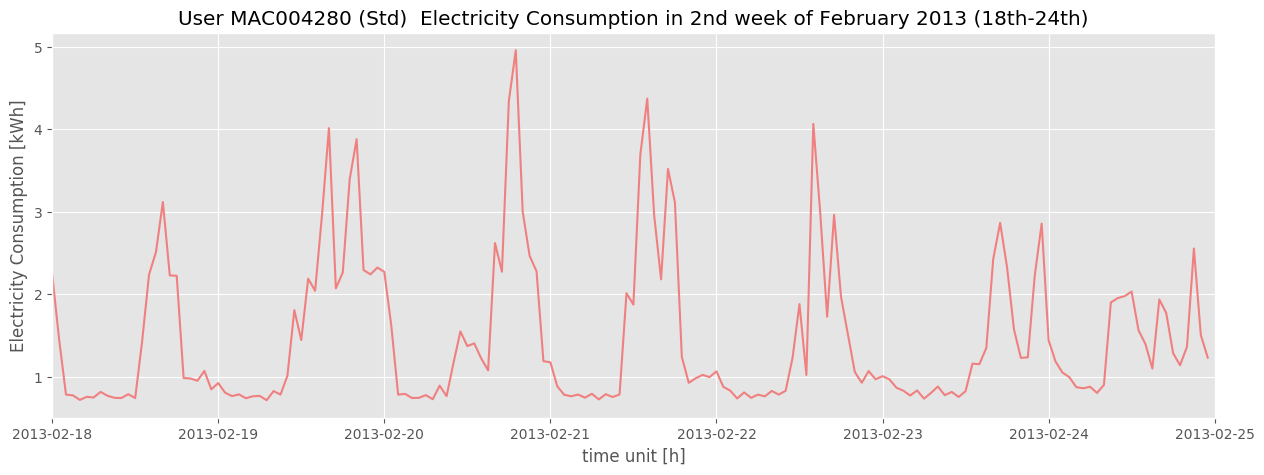

In [213]:
plt.figure(figsize=(15,5))
plt.plot(MAC004280_df_h['2013-02-18':'2013-02-24'], color='lightcoral')
#plt.plot(moving_avg_1h, color='black', linestyle=':' )
# plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
# plt.plot(moving_avg_2h, color='tomato', linestyle=':' )
# plt.plot(moving_avg_12h, color='green', linestyle=':' )
plt.title('User MAC004280 (Std)  Electricity Consumption in 2nd week of February 2013 (18th-24th)')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-18 00:00:00', '2013-02-25 00:00:00')

plt.savefig('../3.Figures/MAC004280.png', dpi=300)
plt.show()

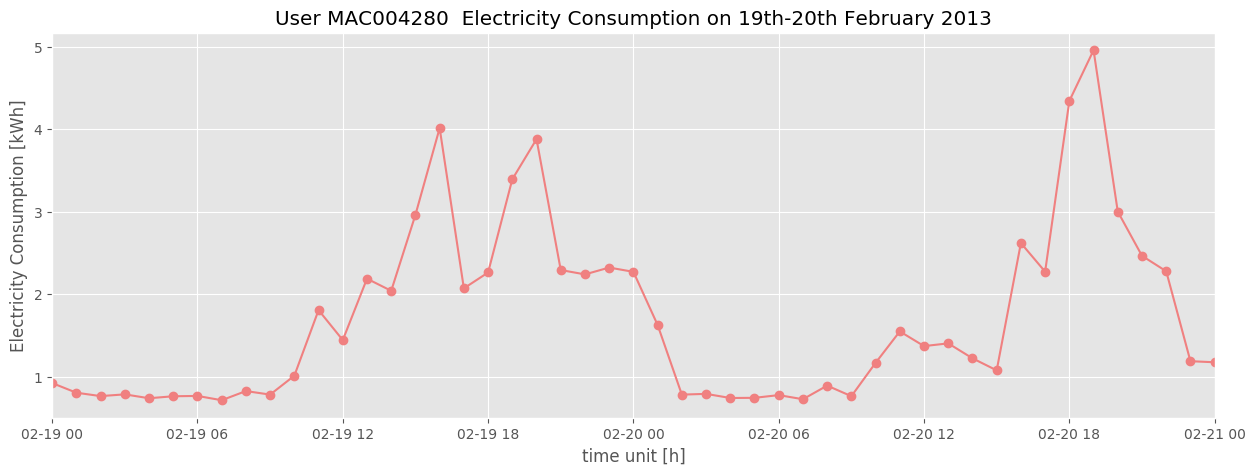

In [214]:
plt.figure(figsize=(15,5))
plt.plot(MAC004280_df_h['2013-02-19':'2013-02-21'], color='lightcoral', marker='o')
#plt.plot(moving_avg_1h, color='black', linestyle=':' )
# plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
#plt.plot(moving_avg_2h, color='tomato', linestyle=':' )
# plt.plot(moving_avg_12h, color='green', linestyle=':' )
plt.title('User MAC004280  Electricity Consumption on 19th-20th February 2013')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-19 00:00:00', '2013-02-21 00:00:00')
plt.savefig('../3.Figures/MAC004280_2days.png', dpi=300)
plt.show()

In [400]:
fig = go.Figure()


fig.add_trace(go.Line(x=MAC002645_df_h['2013-02-19':'2013-02-21'].index,
                      y=MAC002645_df_h['2013-02-19':'2013-02-20']['kWh'], name="MAC002645"));


fig.add_trace(go.Line(x=MAC004280_df_h['2013-02-19':'2013-02-21'].index,
                      y=MAC004280_df_h['2013-02-19':'2013-02-20']['kWh'], name="MAC004280"));


fig.update_layout(
    title=go.layout.Title(text="MAC004280 and MAC002645 Users Electricity Consumption", xref="paper", x=0),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Date", font=dict(family="Courier New, monospace",
                          size=18, color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Electricity consumption [kWh]",
                          font=dict(family="Courier New, monospace", size=18, color="#7f7f7f"))))

fig.show()



### 2.3 ToU users analysis
#### 2.3.1. ToU User: MAC001495


In [326]:
MAC001495_df = half_hourly_df[half_hourly_df['LCLid']=='MAC001495']
MAC001495_df_h = MAC001495_df.copy()
MAC001495_df_h = df_arrange(MAC001495_df_h , 'LCLid', 'DateTime' )

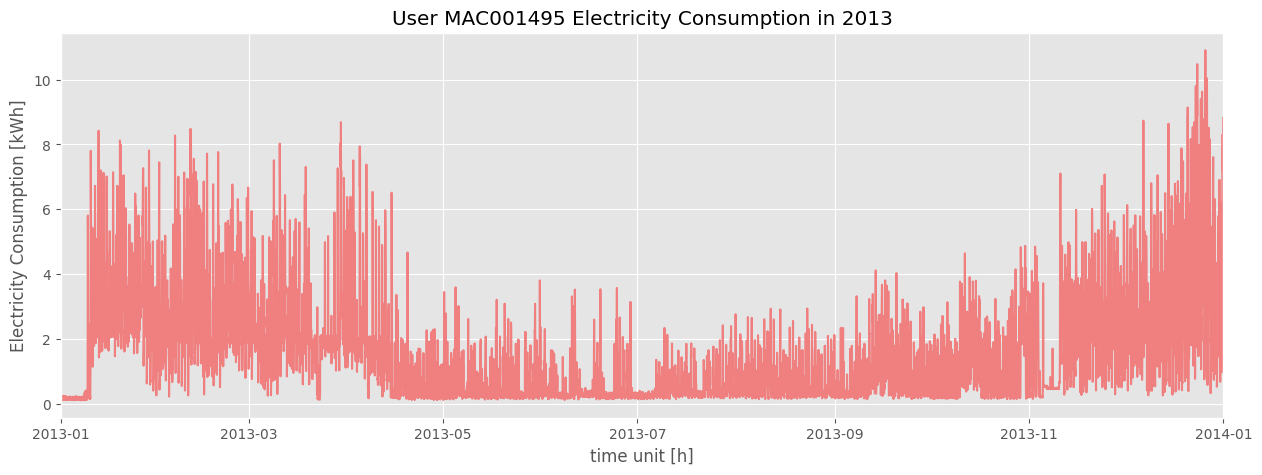

In [216]:
plt.figure(figsize=(15,5))
plt.plot(MAC001495_df_h['2013'], color='lightcoral')
#plt.plot(moving_avg_24h, color='royalblue' )
plt.title('User MAC001495 Electricity Consumption in 2013')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-01-01 00:00:00', '2014-01-01 00:00:00')
plt.show()

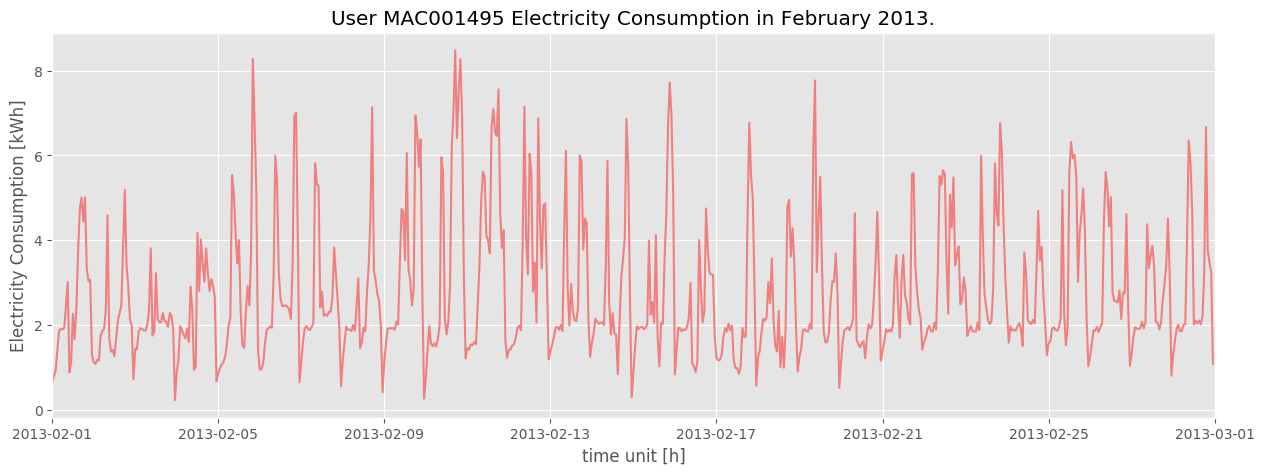

In [217]:
plt.figure(figsize=(15,5))
plt.plot(MAC001495_df_h['2013-02'], color='lightcoral')
#plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
plt.title('User MAC001495 Electricity Consumption in February 2013.')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-01 00:00:00', '2013-03-01 00:00:00')
plt.show()

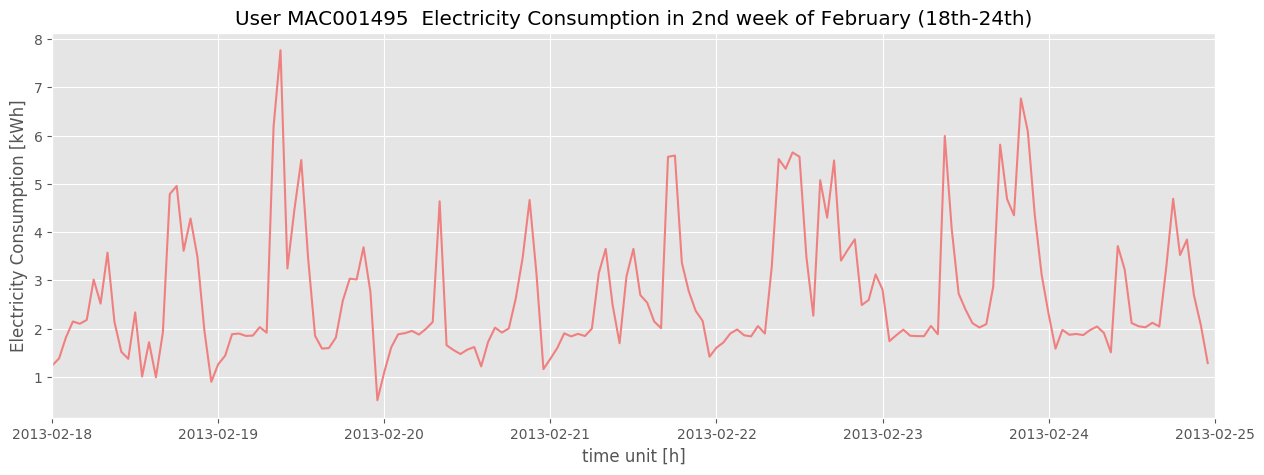

In [218]:
plt.figure(figsize=(15,5))
plt.plot(MAC001495_df_h['2013-02-18':'2013-02-24'], color='lightcoral')
#plt.plot(moving_avg_1h, color='black', linestyle=':' )
# plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
# plt.plot(moving_avg_2h, color='tomato', linestyle=':' )
# plt.plot(moving_avg_12h, color='green', linestyle=':' )
plt.title('User MAC001495  Electricity Consumption in 2nd week of February (18th-24th)')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-18 00:00:00', '2013-02-25 00:00:00')
plt.show()

#### 2.3.2. ToU User: MAC002645

In [327]:
MAC002645_df = half_hourly_df[half_hourly_df['LCLid']=='MAC002645']
MAC002645_df_h = MAC002645_df.copy()
MAC002645_df_h = df_arrange(MAC002645_df_h , 'LCLid', 'DateTime' )

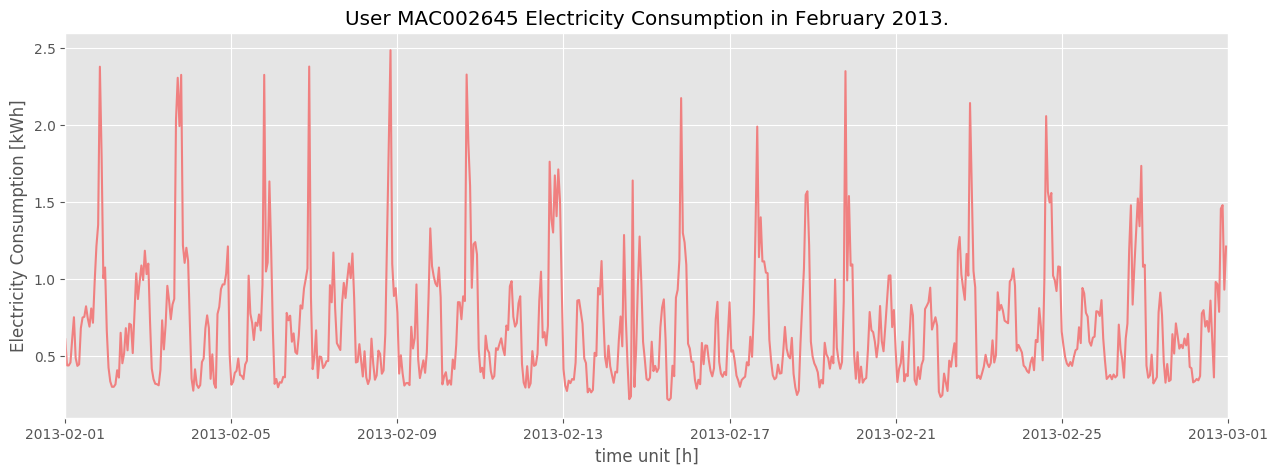

In [328]:
plt.figure(figsize=(15,5))
plt.plot(MAC002645_df_h['2013-02'], color='lightcoral')
#plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
plt.title('User MAC002645 Electricity Consumption in February 2013.')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-01 00:00:00', '2013-03-01 00:00:00')
plt.show()

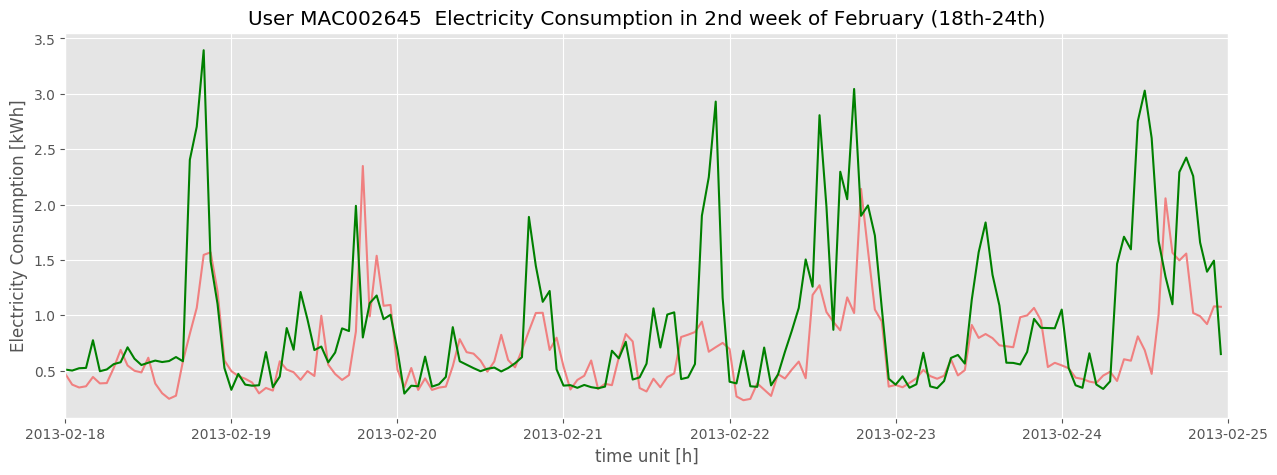

In [221]:
plt.figure(figsize=(15,5))
plt.plot(MAC002645_df_h['2013-02-18':'2013-02-24'], color='lightcoral')
#plt.plot(MAC004280_df_h['2013-02-18':'2013-02-24'], color='royalblue')
plt.plot(MAC000291_df_h['2013-02-18':'2013-02-24'], color='green')
#plt.plot(moving_avg_1h, color='black', linestyle=':' )
# plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
# plt.plot(moving_avg_2h, color='tomato', linestyle=':' )
# plt.plot(moving_avg_12h, color='green', linestyle=':' )
plt.title('User MAC002645  Electricity Consumption in 2nd week of February (18th-24th)')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-18 00:00:00', '2013-02-25 00:00:00')


plt.show()

### Conclusions

From the analysis above we can conclude that the majority of our users 


## 3. Clustering clients 

Our second objective of the project is to be able to perform a market segmentation of our clients based on their electricity consumption. For this reason, we would like to perform a clustering of our clients to know if we could create new tariffs for them. In this case, we are using the dataset that contains all the information regarding their daily consumption.

Our first question here is: 

**Can we classify our clients only considering their daily consumption?** 

or, otherwise, 

**We need more granularity and we should analyze their daily consumption in an hourly timescale?**

In this first chapter we want to analyze if we can classify our clients just considering their daily consumption.

### 3.1. Daily data preprocessing

In [222]:
# Reading the csv file 
clients_cons = pd.read_csv('../0.Data/raw_data/daily_dataset.csv')

In [223]:
# Taking a look on the df 
clients_cons.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066


In [224]:
# Checking the types in our df. 
clients_cons.dtypes

LCLid             object
day               object
energy_median    float64
energy_mean      float64
energy_max       float64
energy_count       int64
energy_std       float64
energy_sum       float64
energy_min       float64
dtype: object

In [225]:
# Changing the type of the day column into datetime for a better analysis. 
clients_cons['day'] = pd.to_datetime(clients_cons['day'])

In [226]:
# Checking the types in our df. 
clients_cons.dtypes

LCLid                    object
day              datetime64[ns]
energy_median           float64
energy_mean             float64
energy_max              float64
energy_count              int64
energy_std              float64
energy_sum              float64
energy_min              float64
dtype: object

In [227]:
# Checking how many observations the df has. 
clients_cons.shape

(3510433, 9)

We want to analyse whether we have the same amount of measurements for each end-user. We know that each measure coming from the smart meter is taken in a half-hour basis. That means that we should have 48 measurements per day. 

For this reason, if we only have one measure, it would be better to drop this measure out of the model. Also, because if we only have one measure in our model, it is not possible to calculate the standard deviation on that day. 

In [329]:
# Checking how many measurements we have in total in our dataframe. 
clients_cons['energy_count'].value_counts().sort_index(ascending=False).head(20)

48    3469352
47      21209
46       1005
45        426
44        290
43        252
42        204
41        164
40        233
39        112
38         92
37         69
36         56
35         39
34         43
33         39
32        274
31        399
30        529
29        544
Name: energy_count, dtype: int64

In [330]:
# Checking how many measurements we have for each user. 
clients_cons['LCLid'].value_counts().head(20)

MAC000157    828
MAC000156    828
MAC000150    828
MAC000153    828
MAC000145    828
MAC000152    828
MAC000147    828
MAC000148    828
MAC000155    828
MAC000149    828
MAC000151    828
MAC000159    827
MAC000166    827
MAC000168    827
MAC000158    827
MAC000167    827
MAC000163    827
MAC000162    827
MAC000160    827
MAC000165    827
Name: LCLid, dtype: int64

We can also calculate how many missing values we have in our database. With this is mind, we can calculate the amount of data we would loose if we decide to drop them out of the model.

In [230]:
clients_cons.isna().sum()

LCLid                0
day                  0
energy_median       30
energy_mean         30
energy_max          30
energy_count         0
energy_std       11331
energy_sum          30
energy_min          30
dtype: int64

In the case of the standard deviation, if we drop the rows with missing values, we would loose approximately a 3% of data. Also, in this case, we cannot calculate the standard deviation and include it here. For this reason, we decide to drop them out of the model. 

In [231]:
clients_cons.dropna(inplace= True)

In [232]:
clients_cons.shape

(3499102, 9)

Considering the previous number of rows and the number of rows after droping them out of the model, we can see that we have removed 11331 rows from our model, and that all the missing values were gathered around the same rows. 

In [233]:
# Checking that we no longer have missing values
clients_cons.isna().sum()

LCLid            0
day              0
energy_median    0
energy_mean      0
energy_max       0
energy_count     0
energy_std       0
energy_sum       0
energy_min       0
dtype: int64

After removing all the NaN values, we have to consider if we want in our model some daily information from our user that does not contain the 48 measures a smart meter should do daily. If we calculate the percentage of users on which we have 48 measurements per day, we see that we have:

In [234]:
(clients_cons[clients_cons['energy_count']==48].shape[0]/clients_cons.shape[0])*100

99.14978185831679

In [235]:
clients_cons[clients_cons['energy_count']==48].shape[0]

3469352

More than 99% of data. For this reason, we will remove all the measurements on which we don't have 48 measurements for each day. 

In [236]:
clients_daily_cons = clients_cons[clients_cons['energy_count']==48]

In [237]:
clients_daily_cons.shape

(3469352, 9)

In [238]:
# Checking how many measurements we have in total in our dataframe. 
clients_daily_cons['energy_count'].value_counts().sort_index(ascending=False)

48    3469352
Name: energy_count, dtype: int64

## 3.2. ML Model: Clustering

In our case, we have only two labels for our users, according to the type of tariff that we have. Furthermore, we would like to increment the number of tariff our model has. For this reason, we would go for an Unsupervised Algorithm for Clustering. Under this approach, we would try to work with two different algorithms: 

- K-Means
- DBscan

However, there are some limitations that we should consider in our model. 

1. We have the same amount of users, 5560 clients and each row means the measurements for that user on that specific day. Furthermore, we cannot perform a K-Means analysis analysing repeated users in our time-period. 

2. We are not considering the hourly electricity consumption. Furthermore, we are not taking into account inside the model the end-user behaviour throughout the day. We won't be able to stratify based on the hourly consumption pattern. 

3. The dataset structure in this case has one row for each user and day. Hence, we will have repeated users. This is a limitation for a clustering model, and we should aggregate the data so as to be able to model the clustering model. 

In [239]:
# Checking how many clients we have under study
clients_daily_cons['LCLid'].nunique()

5560

In [240]:
# Taking a look at the dataframe to see how the df looks like. 
clients_daily_cons.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066
5,MAC000131,2011-12-20,0.2180,0.357500,1.077,48,0.287597,17.160,0.066


This dataset explain the consumption statistics for user and day, under 2 years of data. In our case, we will just one year to perform this analysis, 2013.

In [241]:
# Filtering our dataset just for 2013. 
clients_2013 = clients_daily_cons[clients_daily_cons['day']=='2013']

In [242]:
# Checking how this dataset looks like. 
clients_2013_agg.head()

,energy_median,energy_mean,energy_max,energy_std,energy_sum,energy_min,labels
LCLid,,,,,,,
MAC000002,0.1925,0.225000,0.886,0.164066,10.800,0.076,0
MAC000003,0.1730,0.390292,1.966,0.500391,18.734,0.060,1
MAC000004,0.0000,0.036521,0.186,0.069965,1.753,0.000,4
MAC000005,0.0350,0.090396,0.548,0.103488,4.339,0.024,4
MAC000006,0.0000,0.010417,0.045,0.017880,0.500,0.000,4


Since we don't want to perform the clustering model with repeated IDs, we will group by user and the will calculate the mean for the group. That means that we will have the average daily consumption for user in 2013. With that dataset, we will be able to perform the clustering model. 

In [243]:
clients_2013_agg = clients_2013.groupby(by=['LCLid']).mean()

In [244]:
# Checking the shape of this new dataset. 
clients_2013_agg.shape

(5500, 7)

In [245]:
# We no longer need the "energy_count" column, since we have 48 values for each user. We can drop it. 
clients_2013_agg.drop(columns=['energy_count'], inplace=True)

In [246]:
# Taking an overview of the aggregated dataset. 
clients_2013_agg.head()

,energy_median,energy_mean,energy_max,energy_std,energy_sum,energy_min
LCLid,,,,,,
MAC000002,0.1925,0.225000,0.886,0.164066,10.800,0.076
MAC000003,0.1730,0.390292,1.966,0.500391,18.734,0.060
MAC000004,0.0000,0.036521,0.186,0.069965,1.753,0.000
MAC000005,0.0350,0.090396,0.548,0.103488,4.339,0.024
MAC000006,0.0000,0.010417,0.045,0.017880,0.500,0.000


### 3.2.1 K-Means model

Once the data preprocessing has been done, we can perform a K-Means model to figure out how many clusters for our clients we can have. 

First of all, we will perform some basic statistics in our aggregated dataset to see if we need to Scale our data or not. 

In [247]:
# Taking a look at basic statistics 
clients_2013_agg.describe()

,energy_median,energy_mean,energy_max,energy_std,energy_sum,energy_min
count,5500.000000,5500.000000,5500.000000,5500.000000,5500.00000,5500.00000
mean,0.190798,0.246840,0.907052,0.193609,11.84833,0.06511
std,0.192172,0.213215,0.731140,0.172030,10.23430,0.08947
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
25%,0.075000,0.109354,0.352000,0.071760,5.24900,0.02000
50%,0.138500,0.190844,0.759000,0.150677,9.16050,0.04100
75%,0.236000,0.315719,1.252250,0.265156,15.15450,0.07600
max,2.018000,1.821396,5.893000,1.813486,87.42700,1.34600


We can see that we  have data with a different scale, we need to Scale our data since the range we have in energy_sum is quite different than the range we have for the other variables. Hence, we will import the `StandardScaler` method from *sklearn*. 

In [248]:
# Importing StandardScaler method for SkLearn 
from sklearn.preprocessing import StandardScaler

# Creating the instance for Standard Scaler 
scaler = StandardScaler()

# Fitting the scaler with clients_2013_agg df 
scaler.fit(clients_2013_agg)

# Transforming the clients_2013_agg df into an scaled one. 
clients_2013_agg_scaled = pd.DataFrame(scaler.transform(clients_2013_agg))

In [249]:
clients_2013_agg_scaled.head()

,0,1,2,3,4,5
0,0.008858,-0.102442,-0.028795,-0.171749,-0.102442,0.121726
1,-0.092622,0.672864,1.448483,1.783474,0.672864,-0.057122
2,-0.992938,-0.986511,-0.986291,-0.718800,-0.986511,-0.727802
3,-0.810793,-0.733808,-0.491129,-0.523918,-0.733808,-0.459530
4,-0.992938,-1.108953,-1.179158,-1.021597,-1.108953,-0.727802


One of the hyperparameters in KMeans algorithms is he number of clusters we want to use for the model. However, we could have no idea of which to choose in this model. For this reason, implementing an Elbow curve can be helpful for us so as to choose the best hyperparameter for our model. In this case, we will use **inertia** as a metric to figure out which is the performance of the model in each case.

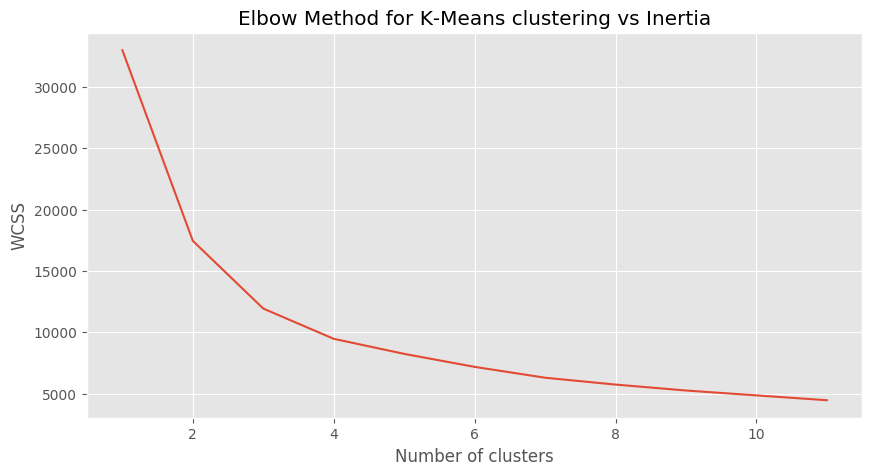

In [336]:
# Importing the library for KMeans 
from sklearn.cluster import KMeans

# Creating an empty list 
wcss = []

# Creating a for loop for clusters between 1 and 12. 
# We create an instance, we fit the model and calculate the inertia 
for i in range(1, 12):

    kmeans = KMeans(n_clusters = i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 42)

    kmeans.fit(clients_2013_agg_scaled)

    wcss.append (kmeans.inertia_)

# Plotting the inertia in front of each iteration 
plt.figure(figsize=(10,5))
plt.plot(range(1, 12), wcss)

# Setting aesthetics of the plot. 
plt.title('Elbow Method for K-Means clustering vs Inertia')

plt.xlabel('Number of clusters')

plt.ylabel('WCSS')

plt.savefig('../3.Figures/Elbow_method.png', dpi=300)
plt.show()

From the plot above we can see that the elbow is not clearly a corner. On the contrary, the elbow is quite soft and so we cannot state that there would be a unique value for **k**. However, from that elbow graph we could state that k would be in the range between 3 and 6. 

There's another method to analyse the performance of the model by means of the hierarchical algorithm method. This method calculates the distance based on the number of k-clusters. A dendogram is a type of tree diagram showing hierarchical clustering and relationships between similars sets of data. When the distance is higher, it means that we have great significant differences. 

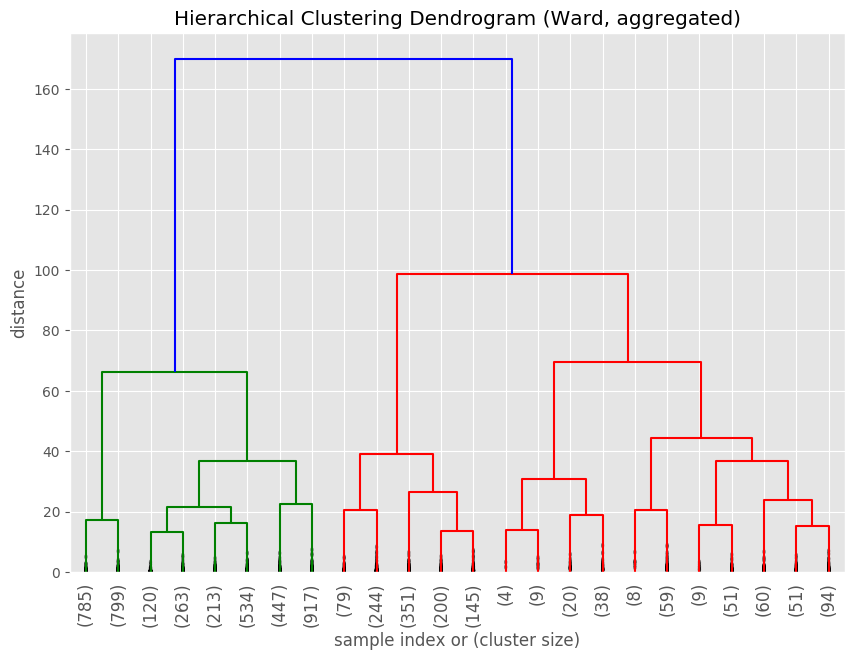

In [335]:
# Hierarchical algorithm for clustering. Import hierarchical algorithm method. 
from scipy.cluster.hierarchy import dendrogram, linkage

# Creating a new hierarchical algorithm  
linkage_matrix = linkage(clients_2013_agg_scaled, 'ward')

# Creating the figure 
figure = plt.figure(figsize=(10, 7))

# The hierarchical algorithm will be reduced, only showing the converged clusters.
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=24,                   # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,   # to get a distribution impression in truncated branches
)

# Setting aesthetics of the plot 
plt.title('Hierarchical Clustering Dendrogram (Ward, aggregated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.savefig('../3.Figures/dendogram.png', dpi=300)
plt.show()

From the graph above in the Hierarchical clustering, we can see that choosing 3 or 5 clusters can be enough for us to classify our end-users.

### 3.2.1.1.  Defining a K-Means model with k=6

First of all, and also according to our knowledge, we establish to define a K-Means model with k=6 clusters to see the performance of the model. 

In [252]:
# We assume 6 clusters 
kmeans = KMeans(n_clusters=6)

# Fitting the input data
kmeans.fit(clients_2013_agg_scaled)

# Including the labels in the database 
clients_2013_agg['labels'] = kmeans.labels_

Once the model has been fit and predicted, we can create a new column where the labels for each client that we have predicted based on the model. Also, we can see the number of clients that we will have under each label. 

In [253]:
# Counting the number of clients under each label. 
clients_2013_agg['labels'].value_counts()

0    2356
3    1964
5     591
1     375
2     151
4      63
Name: labels, dtype: int64

Since we have a total amount of 6 features in our model, we cannot plot all the variables in one plot. For this reason we decide to create a 3D plot including some of the features, the ones that we think that could be the most representative of the model. In this case, we decide to create a plot with `energy_sum`, `energy_mean`, `energy_std`.

In [182]:
# Setting the style parameters as default 
mpl.rcParams.update(mpl.rcParamsDefault)

No handles with labels found to put in legend.


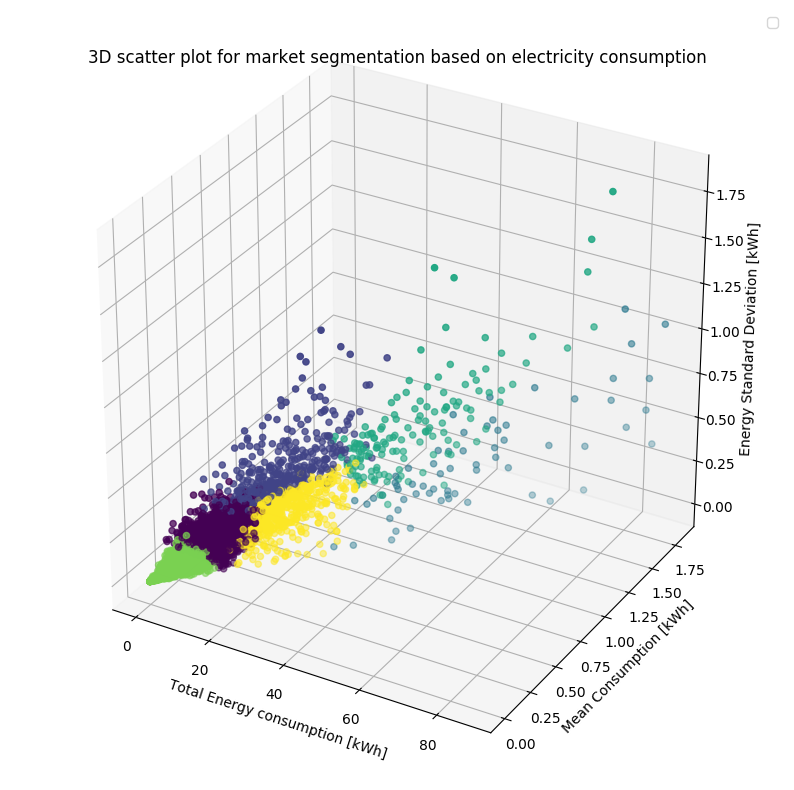

In [187]:
# Importing matplotlib 3d library
from mpl_toolkits.mplot3d import Axes3D

# Setting the figure and creating a 3d subplot
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3 variables: weight, height and gender, stratified by label 
ax.scatter(clients_2013_agg["energy_sum"], clients_2013_agg["energy_mean"], clients_2013_agg["energy_std"], c= clients_2013_agg["labels"])

# Setting aesthetics for electricity consumption clustering figure 
ax.set_xlabel("Total Energy consumption [kWh]")
ax.set_ylabel("Mean Consumption [kWh]")
ax.set_zlabel("Energy Standard Deviation [kWh]")
ax.set_title("3D scatter plot for market segmentation based on electricity consumption", loc='center' )

# Saving the figure into a png file
plt.savefig('../3.Figures/3D_scatter_plot.png', dpi=300)
plt.show()

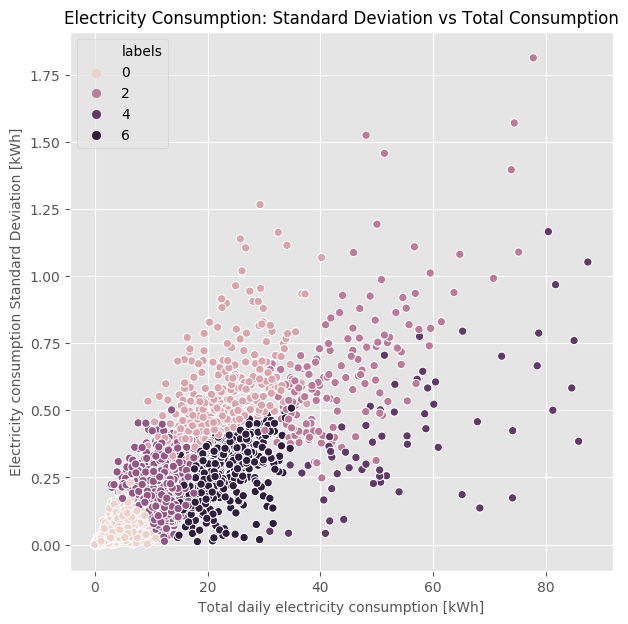

In [267]:
# Plotting the scatter plot between total energy and std, clustering according the labels
plt.figure(figsize=(7,7))
sns.scatterplot(clients_2013_agg["energy_sum"], clients_2013_agg["energy_std"], hue= clients_2013_agg["labels"])

# Setting aesthetics of the plot
plt.title('Electricity Consumption: Standard Deviation vs Total Consumption', fontsize=12)
plt.xlabel('Total daily electricity consumption [kWh]', fontsize=10)
plt.ylabel('Electricity consumption Standard Deviation [kWh]', fontsize=10)

# Saving the plot into a png file
plt.savefig('../3.Figures/std_total_k6.png', dpi=300)
plt.show()

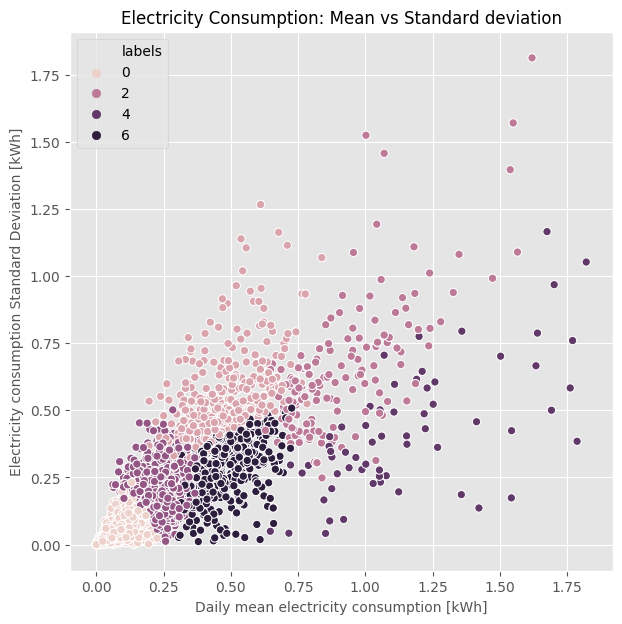

In [271]:
# Plotting the relation between mean and std, stratified by our labels.
plt.figure(figsize=(7,7))
sns.scatterplot(clients_2013_agg["energy_mean"], clients_2013_agg["energy_std"], hue= clients_2013_agg["labels"])

# Setting aesthetics of the plot
plt.title('Electricity Consumption: Mean vs Standard deviation', fontsize=12)
plt.xlabel('Daily mean electricity consumption [kWh]', fontsize=10)
plt.ylabel('Electricity consumption Standard Deviation [kWh]', fontsize=10)

# Saving the plot into a png file
plt.savefig('../3.Figures/mean_std_k6.png', dpi=300)
plt.show()

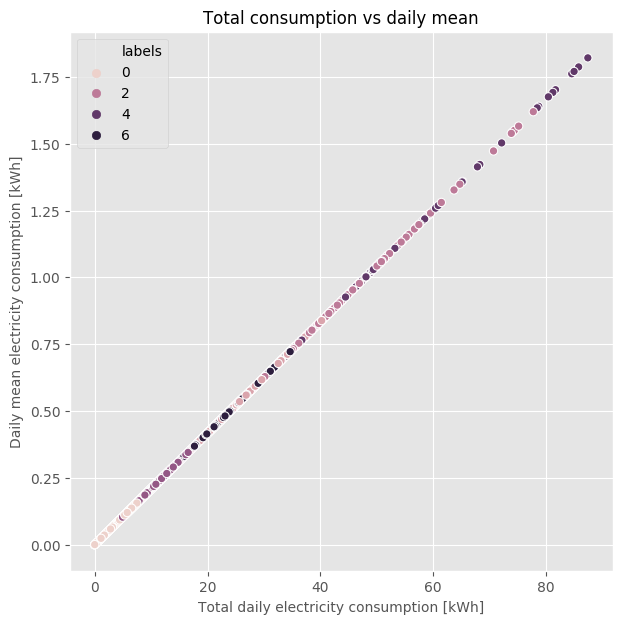

In [272]:
# Plotting the relation between total energy consumption and mean, stratified by our labels.
plt.figure(figsize=(7,7))
sns.scatterplot(clients_2013_agg["energy_sum"], clients_2013_agg["energy_mean"], hue= clients_2013_agg["labels"])

# Setting aesthetics of the plot
plt.title('Total consumption vs daily mean', fontsize=12)
plt.xlabel('Total daily electricity consumption [kWh]', fontsize=10)
plt.ylabel('Daily mean electricity consumption [kWh]', fontsize=10)

# Saving the plot into a png file
plt.savefig('../3.Figures/total_mean_k6.png', dpi=300)
plt.show()

In [260]:
print(f"The inertia of the model with k= 6 is {kmeans.inertia_}")

The inertia of the model with k= 6 is 7172.617989546468


Considering the plots above, we can extract some conclusions on the model. What we can see from the 3D plot is that we are creating such clusters based on the consumer's electricity consumption. However, when we plot these 3 variables, we might say that at least two of them are correlated, as can be seen in the plot above. The total electricity consumption and the daily mean are strictly correlated. This is due to the fact than, the greater the total electricity consumption is, the greater the daily mean will be. 

However, when we plot the 2D plot with total daily electricity consumption vs standard deviation we can see that there such clusters in our model. The same happens when we plot the daily mean vs the standard deviation. This is because we can have clients with a narrow standard deviation, meaning that their variability in their electricity consumption is not as great as other consumers that can have great differences in their daily consumption time periods. 

Taking into account the Elbow Method Figure, the Hierarchical Dendogram and the inertia of the model with k=6, we can conclude that this model perfoms fine and that we can create such clusters, but for sure we can decrease the number of clusters into 3, because the number of clients we have in clusters 3,4,5 is very low compared to clusters 0, 1, 2.

### 3.2.1.2.  K-Means with k = 3 clusters

In [293]:
# We assume 3 clusters 
kmeans_3 = KMeans(n_clusters=3)

# Fitting the input data
kmeans_3.fit(clients_2013_agg_scaled)

# Including the labels in the database 
clients_2013_agg['labels_k3'] = kmeans_3.labels_

In [294]:
print(f"The inertia of the model with k= 6 is {kmeans_3.inertia_}")

The inertia of the model with k= 6 is 11928.69438366065


In [299]:
# Counting the number of clients under each label. 
clients_2013_agg['labels_k3'].value_counts()

1    3667
0    1614
2     219
Name: labels_k3, dtype: int64

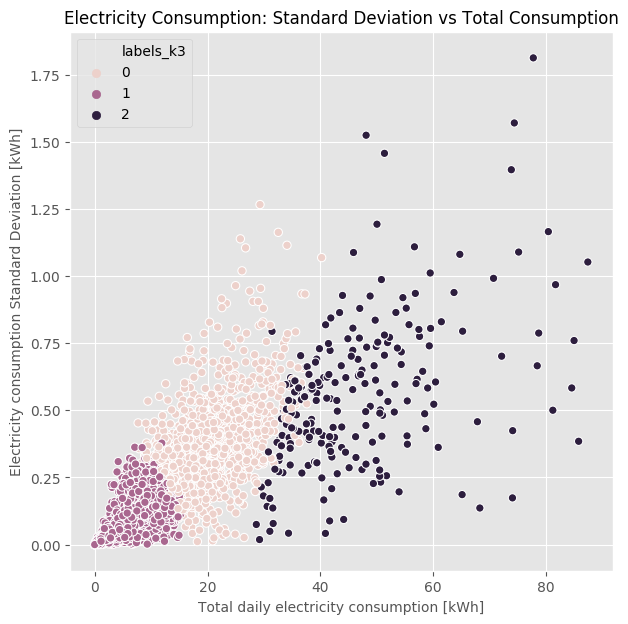

In [295]:
# Plotting the scatter plot between total energy and std, clustering according the labels
plt.figure(figsize=(7,7))
sns.scatterplot(clients_2013_agg["energy_sum"], clients_2013_agg["energy_std"], hue= clients_2013_agg["labels_k3"])

# Setting aesthetics of the plot
plt.title('Electricity Consumption: Standard Deviation vs Total Consumption', fontsize=12)
plt.xlabel('Total daily electricity consumption [kWh]', fontsize=10)
plt.ylabel('Electricity consumption Standard Deviation [kWh]', fontsize=10)

# Saving the plot into a png file
plt.savefig('../3.Figures/std_total_k3.png', dpi=300)
plt.show()

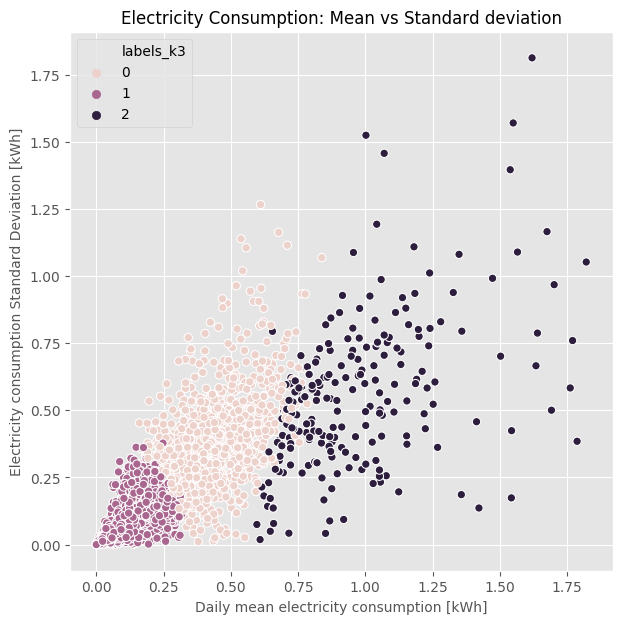

In [297]:
# Plotting the relation between mean and std, stratified by our labels.
plt.figure(figsize=(7,7))
sns.scatterplot(clients_2013_agg["energy_mean"], clients_2013_agg["energy_std"], hue= clients_2013_agg["labels_k3"])

# Setting aesthetics of the plot
plt.title('Electricity Consumption: Mean vs Standard deviation', fontsize=12)
plt.xlabel('Daily mean electricity consumption [kWh]', fontsize=10)
plt.ylabel('Electricity consumption Standard Deviation [kWh]', fontsize=10)

# Saving the plot into a png file
plt.savefig('../3.Figures/mean_std_k3.png', dpi=300)
plt.show()

### 3.2.2. DBSCAN Model

One of the advantages of using DBScan instead of KMeans is that the algorithm does not need the number of cluster that we want to create, the algorithm decided how many clusters are required to classify significantly different data. The hyperparameters of DBscan are: 

   `eps:` specifies how close points should be to each other to be considered a part of a cluster. It means that if the distance between two points is lower or equal to this value (eps), these points are considered neighbors.

   `minPoints:` the minimum number of points to form a dense region. For example, if we set the minPoints parameter as 5, then we need at least 5 points to form a dense region.
   
In this section we are performing a model using DBscan with the hyperparameter eps=0.5 and min_samples or minPoints= 100. We will need at least 100 users to create a new cluster and so a new type of tariff.

In [290]:
from sklearn.cluster import DBSCAN

model_DBSCAN = DBSCAN(eps=0.5, min_samples=100)

model_DBSCAN.fit(clients_2013_agg_scaled)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=100, n_jobs=None, p=None)

In [291]:
clients_2013_agg['labels_DBSCAN'] = model_DBSCAN.labels_

In [292]:
clients_2013_agg['labels_DBSCAN'].value_counts()

 0    4180
-1    1320
Name: labels_DBSCAN, dtype: int64

According to the hyperparameters we have chosen, we only create two clusters, with nearly the same amount of users we have right now in Standard and ToU tariffs. 

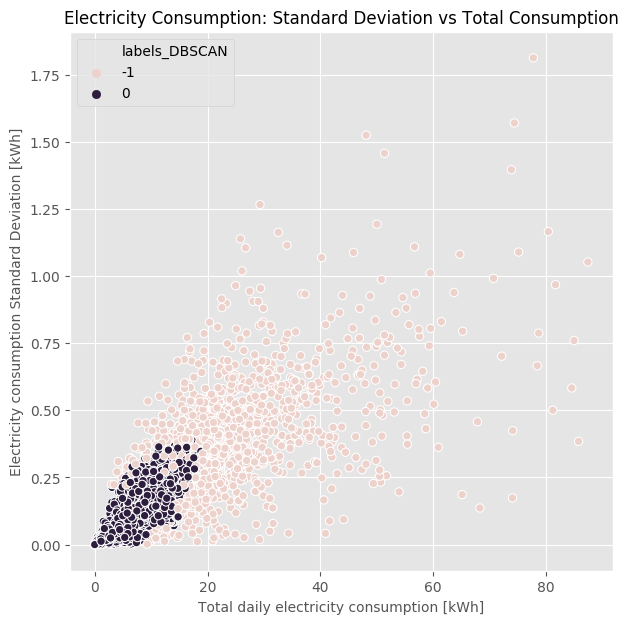

In [296]:
# Plotting the scatter plot between total energy and std, clustering according the labels
plt.figure(figsize=(7,7))
sns.scatterplot(clients_2013_agg["energy_sum"], clients_2013_agg["energy_std"], 
                hue= clients_2013_agg["labels_DBSCAN"])

# Setting aesthetics of the plot
plt.title('Electricity Consumption: Standard Deviation vs Total Consumption', fontsize=12)
plt.xlabel('Total daily electricity consumption [kWh]', fontsize=10)
plt.ylabel('Electricity consumption Standard Deviation [kWh]', fontsize=10)

# Saving the plot into a png file
plt.savefig('../3.Figures/std_total_DBSCAN.png', dpi=300)
plt.show()

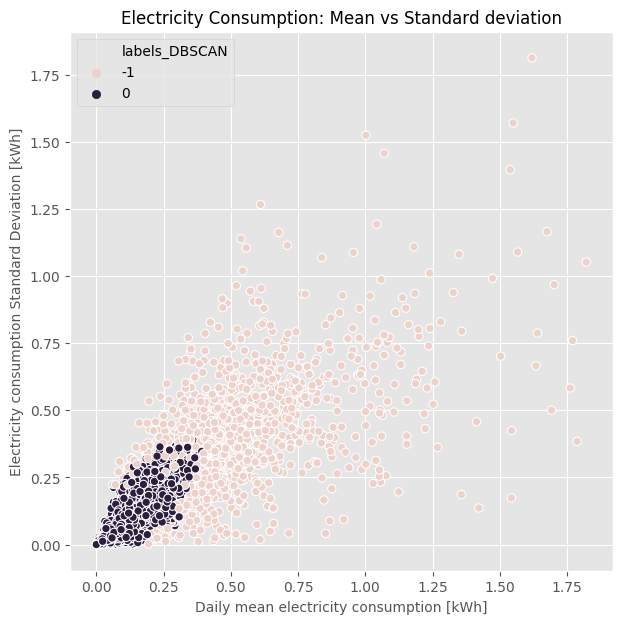

In [298]:
# Plotting the relation between mean and std, stratified by our labels.
plt.figure(figsize=(7,7))
sns.scatterplot(clients_2013_agg["energy_mean"], clients_2013_agg["energy_std"], 
                hue= clients_2013_agg["labels_DBSCAN"])

# Setting aesthetics of the plot
plt.title('Electricity Consumption: Mean vs Standard deviation', fontsize=12)
plt.xlabel('Daily mean electricity consumption [kWh]', fontsize=10)
plt.ylabel('Electricity consumption Standard Deviation [kWh]', fontsize=10)

# Saving the plot into a png file
plt.savefig('../3.Figures/mean_std_DBSCAN.png', dpi=300)
plt.show()

- KMeans is much faster than DBScan
- DBScan doesn't need number of clusters 
- DBScan doesn't work well over clusters with different densities. 

In this case, we don't know the number of clusters and so DBScan can help us to decide how many clusters we need. Also, we are not dealing with a huge amount of data and so both algorithms are fast enough. However, in our model we have different densities, meaning that we would need to rely on K-Means rather than on DBSCAN.

## 3.3. Conclusions

The Business As Usual (BAU) scenario considers that we only have two tariffs. Furthermore, these two tariff just take into account the time period of energy consumption, but not the distribution of the consumption itself. In our case, we analyze the basic statistics of the daily energy consumption by considering the standard deviation, the mean, the minimum value, the maximum value, and the total consumption on that day. Implicitely, we are considering in such a way the distribution of the electricity consumption alongside the day. 

According to the results obtained in the model, thanks to the Elbow method calculation and the Dendogram we can decide the best cluster value according to our metrics, inertia in this case. We have chosen two cases, k=3 and k=6 to see the performance of the model. 

With k=6 we can see that there is a distributed number of clusters, but according to the elbow curve there should probably be a greater number that the required for splitting the tariffs. In k=3 scenario, we can cleary see 3 clusters according to their daily consumption stats. 

A DBSCAN model has also been developed, to see if a different number of clusters would have been obtained. In this case, 2 clusters were presented. However,the clusters were not representative since the shape of them does not indicate different consumption patterns. Also, as has been said before, DBSCAN does not perform well when clusters have different densities, and this is the case of our study. Maybe in a future work, some of the clients could be considered as outliers of the model to be general enough and then DBSCAN could be implemented with better results. 

For this reason, we would conclude that the best model would be a K-Means model with 3 clusters and the following summary. 

- Cluster 0: 

    These users have the lowest daily energy consumption, as well as a lower standard deviation. That mean that these are users that they not consume a lot of electricity, maybe bacause they have also different energy sources such as natural gas. Also, a low standard deviation means that these consumers don't have peak hours or off-peak hours of consumption. This could be considered as the current *Standard* tariff. 
    
    
- Cluster 1: 

    In this case, the users under this group have a greater electricity consumption, meaning that maybe they are a family, or that they rely on electricity consumption and not in other sources such as natural gas. As well, in this second group the standard deviation is quite high compared to the other group. That means that our users will have peak hours and off peak hours of consumption. This would be similar to the *ToU* tariff.  However, this group could maybe be split into two if more information about the consumption during the day would be known. 


- Cluster 2: 

    This last group gather those users with a great daily electricity consumption, as well as a great standard deviation. For example, we know that one independent house in Europe consumes averagely 16.000 kWh/year, meaning that they would consume 45 kWh/day. Hence, in this last group we are considering mostly single family homes as well as companies, on which the electricity consumption would be greater than other flats. 
    
As a further step, in order to perform a good clustering, the daily consumption patterns should be taking into consideration, to see whether more than 3 clusters can be done, in order to evolve into personalized contracts and offers. 